In [4]:
import dopterian.dopterian as dopt
import kcorrections.kcorrections as kk
from astropy.io import fits
import numpy as np
import math
import matplotlib.pyplot as plt
import kcorrect

#Script para probar la ejecucion de dopterian

sci_image = r'D:\Documentos\Diego\U\Memoria Titulo\Dopterian\Input\clash_a209_nir_0990_dopterian_input.fits'
psf = r'D:\Documentos\Diego\U\Memoria Titulo\Dopterian\Input\hlsp_clash_hst_wfc3ir-65mas_all_f160w_v1_psf.fits'
sky_image = r'D:\Documentos\Diego\U\Memoria Titulo\Dopterian\Input\sky_clash_a209_nir_0990_a209_dopterian_input.fits'

output_sci = r'D:\Documentos\Diego\U\Memoria Titulo\Dopterian\Output\clash_a209_nir_0990_dopterian_outpu.fits'
output_psf = r'D:\Documentos\Diego\U\Memoria Titulo\Dopterian\Output\hlsp_clash_hst_wfc3ir-65mas_all_f160w_v1_output_psf.fits'

#leemos los fits

science_hdul = fits.open(sky_image)
sky_data = science_hdul[0].data
science_hdul.close()

science_hdul = fits.open(psf)
psf_data = science_hdul[0].data
science_hdul.close()

science_hdul = fits.open(sci_image)
science_data = science_hdul[0].data
science_header = science_hdul[0].header
science_hdul.close()

#exptime
exptime = science_header['EXPTIME']

#pixscale 

pixscale =  0.065
 
#input_photflam and input_photplam

input_photflam = science_header['PHOTFLAM']
input_photplam = science_header['PHOTPLAM']
log_photflam = np.log10(input_photflam)
log_photplam = np.log10(input_photplam)

#zero point    
zero_point = -2.5 * log_photflam - 5.0 * log_photplam - 2.408


lowz_info  = {'redshift': 0.206, 'psf': psf,'zp': zero_point, 'exptime': exptime, 'filter': 'wfc3_f160w', 'lam_eff': input_photplam, 'pixscale': pixscale}

highz_info  = {'redshift': 2.0, 'psf': psf,'zp': zero_point, 'exptime': exptime, 'filter': 'wfc3_f160w', 'lam_eff': input_photplam, 'pixscale': pixscale}


imOUT, psfOUT = dopt.ferengi(sci_image, sky_image, lowz_info, highz_info, [output_sci, output_psf], imerr=None, noconv=False, evo=None, nonoise=True, extend=False, noflux=True)




<class 'numpy.ndarray'>


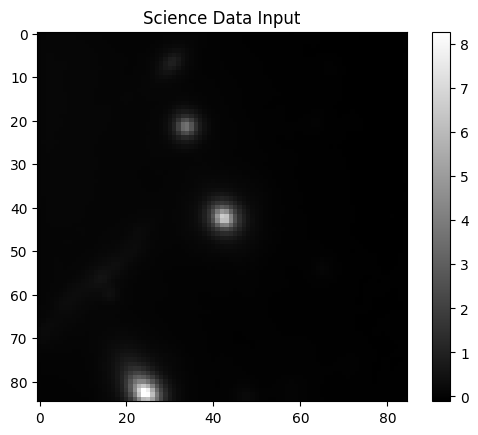

In [5]:
#Visualizamos la imagen de la galaxia simulada a alto redshift
plt.figure()
plt.imshow(imOUT, cmap='gray')
plt.title('Science Data Input')
plt.colorbar()
plt.show()

In [6]:


n_pix_x = science_data.shape[1]
n_pix_y = science_data.shape[0]


# Convertir la matriz de datos de science_data a float32

science_data = science_data.astype(np.float32)
#science_data = imOUT.astype(np.float32)

# Convertir electrons/s a maggies
flux_maggies = dopt.cts2maggies(science_data,exptime, zero_point)


# Definir el error relativo en magnitudes (ejemplo con 0.2 magnitudes)
err = 0.2

# Calcular el error en maggies
err_maggies = flux_maggies * (np.log(10)/2.5) * err

# Asegurarse de que los errores sean finitos y reemplazar valores NaN/Inf
err_maggies = np.where(np.isfinite(err_maggies), err_maggies, np.nan)
err_maggies = np.nan_to_num(err_maggies, nan=1e10, posinf=1e10, neginf=1e10)

# Calcular la varianza inversa (ivar) y asegurarse de que sea finita
with np.errstate(divide='ignore', invalid='ignore'):
    ivar_maggies = 1 / (err_maggies**2)
    ivar_maggies = np.where(np.isfinite(ivar_maggies), ivar_maggies, np.nan)
    ivar_maggies = np.nan_to_num(ivar_maggies, nan=0.0, posinf=0.0, neginf=0.0)

# Convertir ivar_maggies y flux_maggies a float32
ivar_maggies = ivar_maggies.astype(np.float32)
flux_maggies = flux_maggies.astype(np.float32)

# Aplanar las matrices a 1D
ivar_maggies = ivar_maggies.flatten()
flux_maggies = flux_maggies.flatten()



In [7]:
# Número de píxeles
n_pizeles = len(flux_maggies)

# Definir un redshift constante para todos los píxeles (ejemplo con 0.206)
redshift = [lowz_info['redshift']] * n_pizeles

# Definir las respuestas de los filtros utilizados
responses = ['clash_wfc3_f160w']

# Inicializar listas para almacenar los flujos y varianzas inversas por píxel
maggies = [[] for n in range(n_pizeles)]
ivar = [[] for n in range(n_pizeles)]

# Llenar las listas con los datos correspondientes
for i in range(n_pizeles):
    maggies[i].append(flux_maggies[i])
    ivar[i].append(ivar_maggies[i])




In [8]:
# Inicializar el objeto Kcorrect con las respuestas de los filtros
kc = kcorrect.kcorrect.Kcorrect(responses=responses)

print(kc.cosmo)

# Calcular los coeficientes de ajuste para cada píxel
coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)
print(coeffs.shape)

# Calcular las correcciones k para cada píxel

maggies = kc.reconstruct_out(redshift=redshift,coeffs=coeffs)




FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)
(44100, 5)


In [9]:




maggies_image = maggies.reshape((n_pix_y, n_pix_x))




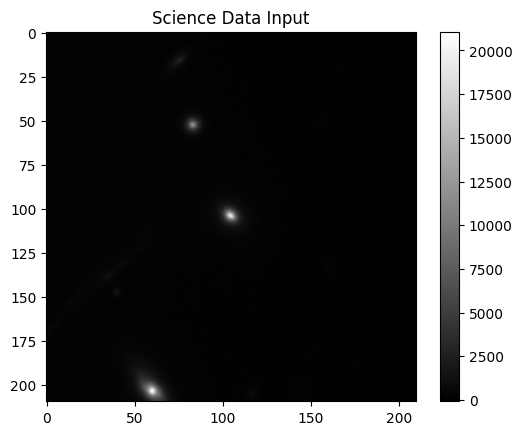

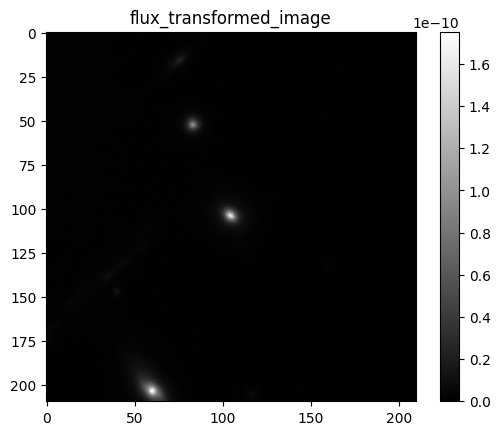

In [10]:
plt.figure()
plt.imshow(science_data, cmap='gray')
plt.title('Science Data Input')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(maggies_image, cmap='gray')
plt.title('flux_transformed_image')
plt.colorbar()
plt.show()


In [11]:
print(kcorrect.response.all_responses())

['alhambra_768', 'alhambra_799', 'alhambra_830', 'alhambra_861', 'alhambra_892', 'alhambra_923', 'alhambra_954', 'alhambra_f365w', 'alhambra_f396w', 'alhambra_f427w', 'alhambra_f458w', 'alhambra_f489w', 'alhambra_f520w', 'alhambra_f551w', 'alhambra_f582w', 'alhambra_f613w', 'alhambra_f644w', 'alhambra_f675w', 'alhambra_f706w', 'alhambra_f737w', 'alhambra_f768w', 'alhambra_f799w', 'alhambra_f830w', 'alhambra_f861w', 'alhambra_f892w', 'alhambra_f923w', 'alhambra_f954w', 'alhambra_H', 'alhambra_J', 'alhambra_KS', 'bass_g', 'bass_r', 'bessell_B', 'bessell_I', 'bessell_R', 'bessell_U', 'bessell_V', 'blah', 'bok_90prime_z', 'capak_cfht_megaprime_sagem_g', 'capak_cfht_megaprime_sagem_i', 'capak_cfht_megaprime_sagem_r', 'capak_cfht_megaprime_sagem_u', 'capak_cfht_megaprime_sagem_z', 'capak_cfht_wircam_Ks', 'capak_subaru_suprimecam_B', 'capak_subaru_suprimecam_g', 'capak_subaru_suprimecam_i', 'capak_subaru_suprimecam_r', 'capak_subaru_suprimecam_V', 'capak_subaru_suprimecam_z', 'capak_ukirt_wfc

In [12]:
()

()